# Data Exploration

The data is downloaded from the [Open University](https://analyse.kmi.open.ac.uk/open_dataset) and contains information on students, modules, presentation and assessments. There is lots more information than is used here. This Exploration only focuses on aspects of the data used in the study.

The image below comes directly from the above website and shows the DB relation structure.

<img src=https://analyse.kmi.open.ac.uk/resources/images/model.png>

We will focus on studentAssessment results of the "Exam" type.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
datapath = 'data/'
all_results = pd.read_csv(datapath+'studentAssessment.csv')
assessments = pd.read_csv(datapath+'assessments.csv')

In [ ]:
print(all_results.shape)
all_results.head()

(173912, 5)


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [ ]:
print(assessments.shape)
assessments.tail()

(206, 6)


,code_module,code_presentation,id_assessment,assessment_type,date,weight
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0
205,GGG,2014J,37444,Exam,229.0,100.0


From the website: code presentation with yyyy(J/B) are separate presentations that may differ in structure, so it may be wise to see one "course" as `code_module`+`code_presentation`. For now, though, I will just use code_module, as that is supposedly the same educational content, just given at another time, in a slightly different structure. We are interested in final grades, which are calculated as follows: the weights of all grades for assessments (other than Exam) add up to 100%, and the Exam has weight 100% as well. The website says nothing about how the grade of a course is calculated, so we will assume it is the average of exam and assessments, if both exist.

In [ ]:
# assessments['course'] = assessments.code_module + assessments.code_presentation
assessments['course'] = assessments.code_module
exams = assessments[assessments.assessment_type == "Exam"]
assessments = assessments[assessments.assessment_type != "Exam"]
print(f'That leaves us with {assessments.shape[0]} assessments and {exams.shape[0]} exams')

That leaves us with 182 assessments and 24 exams


In [ ]:
results = all_results.merge(exams, how='inner', on='id_assessment')#[['id_student', 'course', 'score', 'assessment_type']]
results_assessments = all_results.merge(assessments, how='inner', on='id_assessment')

In [ ]:
print(results.shape)
# print(f'{len(np.unique(results.id_student))} unique students following {len(np.unique(results.course))} courses.')
results.head()

(4959, 11)


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,course
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,CCC
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,CCC
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,CCC
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,CCC
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,CCC


So, added up, per student, per code_module, the weights should be one hundred for all non-exams. Apparently, not everyone handed in everything.

In [ ]:
results_assessments["frac_score"] = results_assessments.weight * results_assessments.score

pcps_weightedscore = results_assessments.groupby(['code_module', 'id_student']).frac_score.sum() / results_assessments.groupby(['code_module', 'id_student']).weight.sum()

pcps = pd.DataFrame(pcps_weightedscore).reset_index().rename(columns={0:'score'})
pcps.head()

,code_module,id_student,score
0,AAA,6516,63.5
1,AAA,11391,82.4
2,AAA,24734,47.5
3,AAA,26192,86.3
4,AAA,28061,77.4


### There are only exams of students for coursed CCC and DDD, while IDs exist for all...

Instead, let's go for exams for a course and assessments for a course as separate course results!

In [ ]:
pcps['code_module'] = pcps.code_module + '_a'
student_results = pd.concat([results[['code_module', 'id_student', 'score']], pcps], axis=0).dropna().rename(
    columns={'id_student':'StudentNumber', 'code_module':'Course', 'score':'Grade'})

In [ ]:
student_results

,Course,StudentNumber,Grade
0,CCC,558914,32.00
1,CCC,559706,78.00
2,CCC,559770,54.00
3,CCC,560114,64.00
4,CCC,560311,100.00
...,...,...,...
22972,FFF_a,2694680,86.50
22973,FFF_a,2697630,66.50
22974,FFF_a,2697885,77.50
22975,FFF_a,2697921,80.25


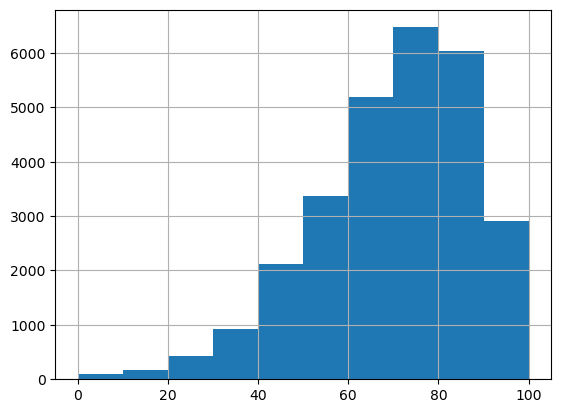

In [ ]:
student_results.Grade.hist();

Let's see if a network can be built out of this. Useless data, almost all students are unique, no overlapping groups.

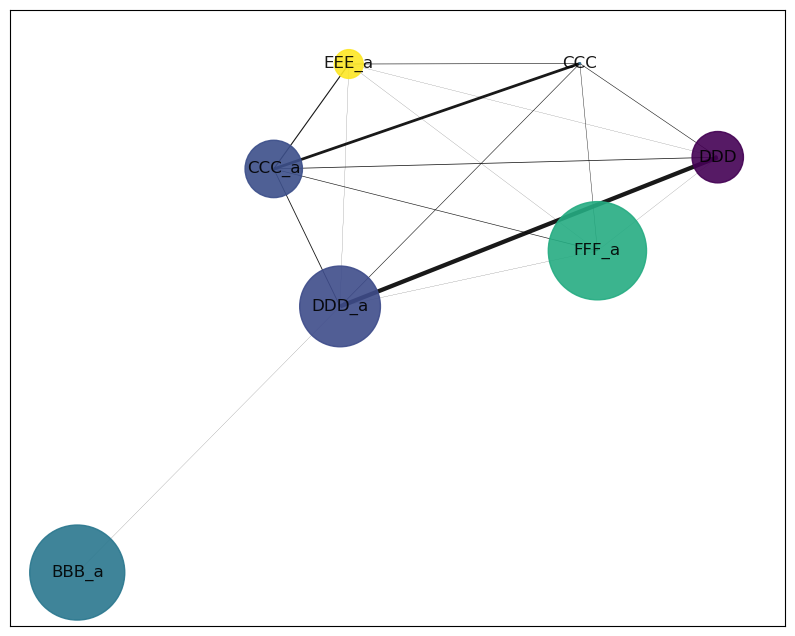

In [ ]:
from utils import course_network, show_course_network
nw = course_network(student_results,
                   min_students_course=10,
                   min_students_overlap=5)
show_course_network(nw, kind="spring")
plt.savefig('figures/network_OU.png')

In [ ]:
np.unique(student_results.Course)

array(['AAA_a', 'BBB_a', 'CCC', 'CCC_a', 'DDD', 'DDD_a', 'EEE_a', 'FFF_a'],
      dtype=object)

In [ ]:
results_network = student_results[student_results.Course.isin(list(nw.nodes))]
print(f'There are {len(np.unique(results_network.StudentNumber))} students')
pd.DataFrame(results_network.groupby('Course').StudentNumber.nunique()).describe().loc[['count', 'mean', 'min', 'max'],:]

There are 20424 students


,StudentNumber
count,7.000000
mean,3862.714286
min,1915.000000
max,6033.000000


In [ ]:
pd.DataFrame(results_network.groupby('Course').Grade.mean())

,Grade
Course,
BBB_a,69.732813
CCC,68.911749
CCC_a,67.283228
DDD,63.472405
DDD_a,67.102553
EEE_a,79.339998
FFF_a,73.209445


In [ ]:
pd.DataFrame(results_network.groupby('Course').Grade.std())

,Grade
Course,
BBB_a,12.840143
CCC,22.707859
CCC_a,23.331187
DDD,18.821687
DDD_a,17.339764
EEE_a,13.432690
FFF_a,14.717142


In [ ]:
pd.DataFrame(results_network.groupby('Course').Grade.count())

,Grade
Course,
BBB_a,5769
CCC,1915
CCC_a,3318
DDD,3044
DDD_a,4696
EEE_a,2268
FFF_a,6033


In [ ]:
results_network.head()

,Course,StudentNumber,Grade
0,CCC,558914,32.0
1,CCC,559706,78.0
2,CCC,559770,54.0
3,CCC,560114,64.0
4,CCC,560311,100.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Course difficulty, Scatter parent distribution, Grade scatter, Course sensitivity, Student ability]


Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 16839 seconds.
The acceptance probability does not match the target. It is 0.9456, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9516, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9434, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9465, but should be close to 0.98. Try to increase the number of tuning steps.


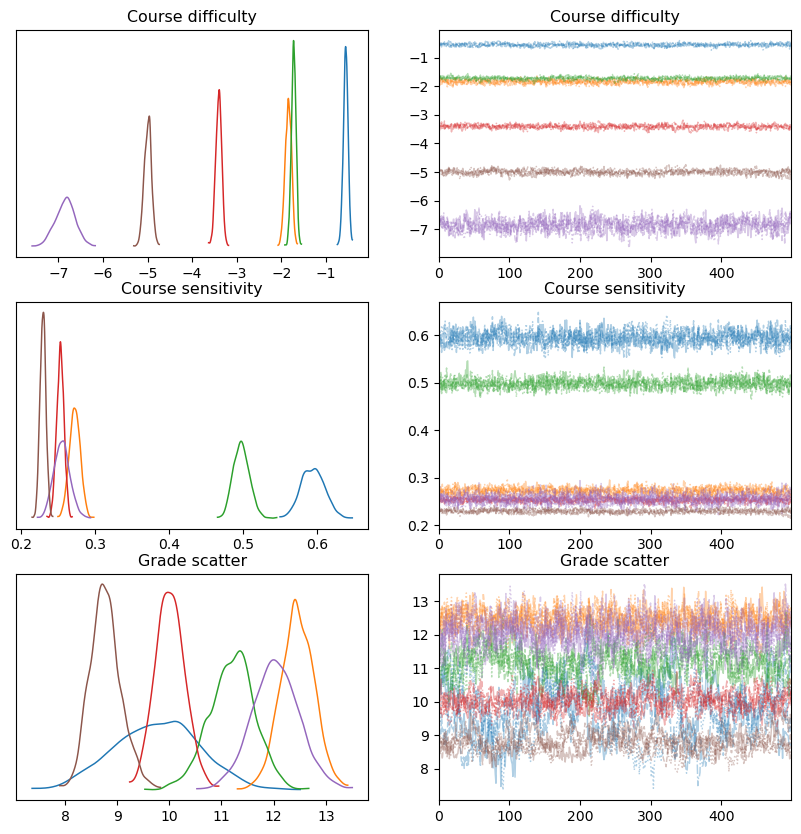

In [22]:
import importlib
importlib.reload(utils)
from utils import model_and_visualize, model_and_visualizeOU
trace, sim = model_and_visualizeOU(results_network[results_network.Course != "BBB_a"])

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Course difficulty, Scatter parent distribution, Grade scatter, Course sensitivity, Student ability]


Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 1349 seconds.
The acceptance probability does not match the target. It is 0.9505, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9532, but should be close to 0.98. Try to increase the number of tuning steps.


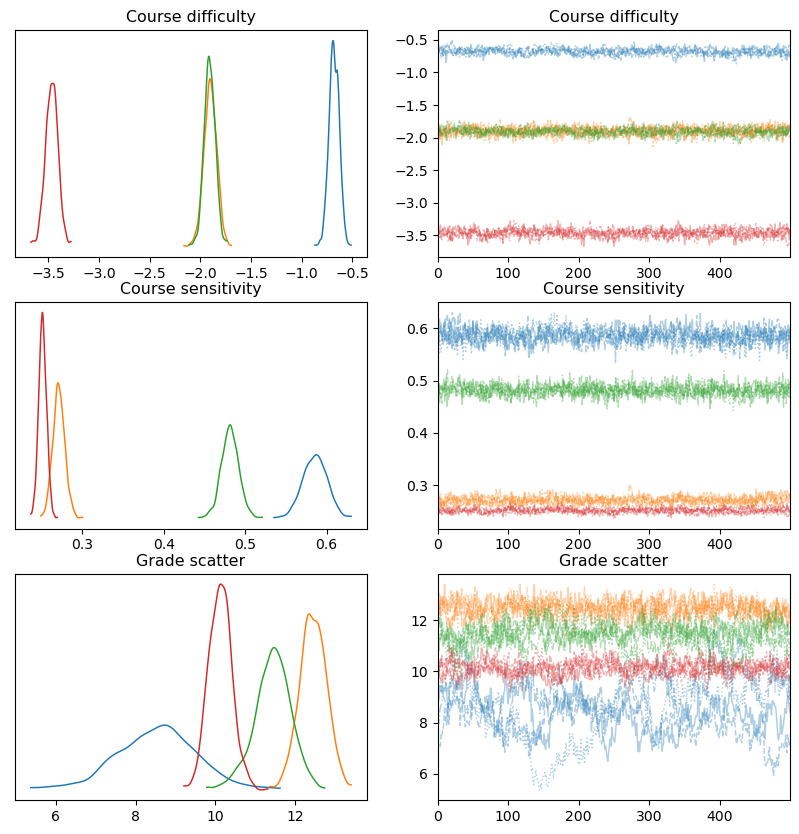

In [23]:
import importlib
import utils
importlib.reload(utils)
from utils import model_and_visualize, model_and_visualizeOU
trace, sim = model_and_visualizeOU(results_network[results_network.Course.isin(['CCC', 'CCC_a', 'DDD', 'DDD_a'])])

In [20]:
# Save the trace, so I don't need to run it all again tomorrow!
import pickle
with open('data/OUtrace.pkl', 'wb') as f:
    pickle.dump(trace, f)


2.3797860445915875


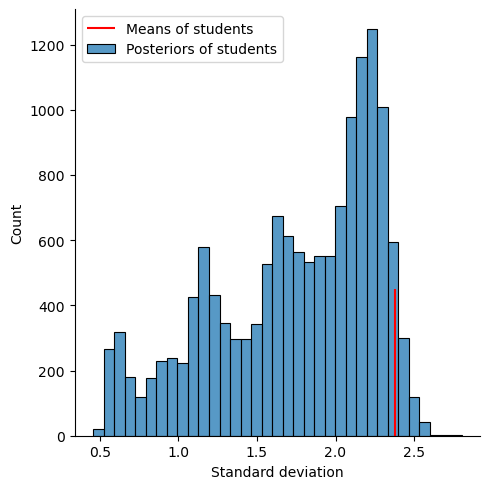

In [25]:
# Looking at student ability from the posteriors
students = az.summary(trace, var_names=["Student ability"])
sd_overall = students["mean"].std()
print(sd_overall)

sns.displot(data=students, x='sd', label='Posteriors of students')
plt.vlines(sd_overall, 0, 450, color='red', label='Means of students')
plt.xlabel('Standard deviation')
# plt.xlim([0,3.2])
plt.legend(loc='upper left');
# plt.savefig('OUstudent_ability_stds.pdf')

In [24]:
import arviz as az
import seaborn as sns

### Nodgreep: verwijder alle studenten die niet minstens 2 vakken doen

## PERHAPS TRY a 3 as MINIMUM as well! Nog maar 1000 regels over...
WERKT PRIMA!

In [87]:
small_group = results_network[results_network.Course != "BBB_a"]
n_ps = small_group.groupby('StudentNumber').Course.nunique()

In [88]:
studs = pd.DataFrame(n_ps[n_ps > 2]).reset_index().rename(columns={'Course':'n_courses'})

In [89]:
studs

,StudentNumber,n_courses
0,29411,3
1,29639,3
2,29820,3
3,35508,3
4,42638,3
...,...,...
1051,2644404,3
1052,2650741,3
1053,2668106,3
1054,2681198,3


In [90]:
stud_numbers = np.unique(studs.StudentNumber)
print("This leaves", len(stud_numbers), " students")
small_group = pd.merge(small_group, studs, on='StudentNumber', how='inner')

This leaves 1056  students


In [79]:
small_group

,Course,StudentNumber,Grade,n_courses
0,CCC,558914,32.000000,4
1,DDD,558914,36.000000,4
2,CCC_a,558914,30.750000,4
3,DDD_a,558914,65.630000,4
4,CCC,559706,78.000000,4
...,...,...,...,...
11820,FFF_a,614181,87.000000,2
11821,EEE_a,615429,87.277778,2
11822,FFF_a,615429,47.000000,2
11823,EEE_a,619292,95.800000,2


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Course difficulty, Grade scatter, Course sensitivity, Student ability]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.


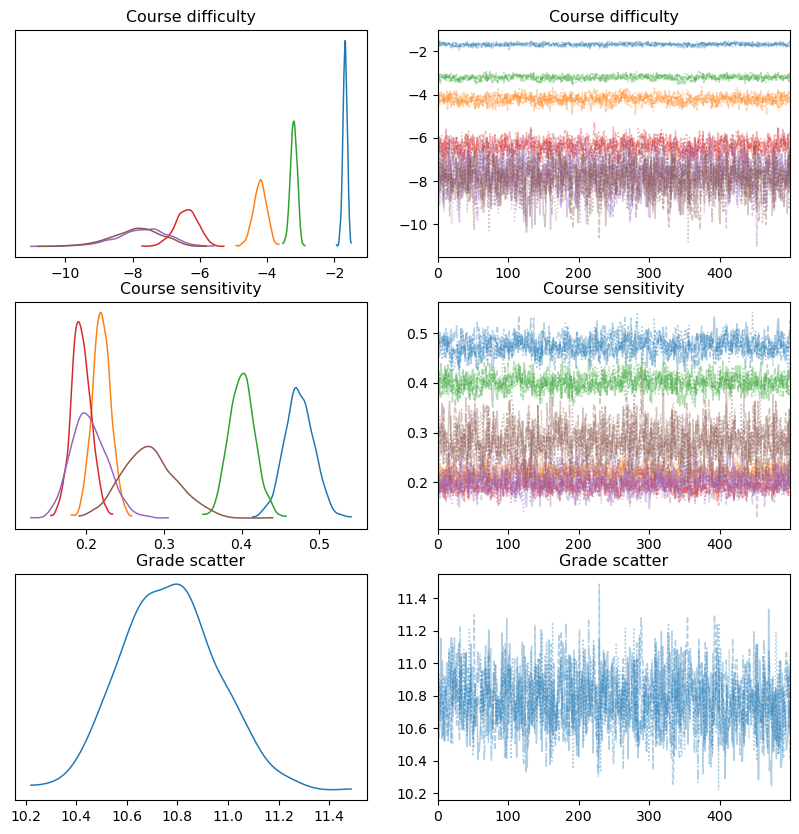

In [91]:
import importlib
import utils
importlib.reload(utils)
trace, sim = utils.model_and_visualize(small_group)

In [86]:
import pickle
with open('data/OUtrace_NUTSratep98_small.pkl', 'wb') as f:
    pickle.dump(trace, f)


Samenvatting: normale nuts, en slechts 1 scatter (mean=10.8) werkt goed voor iedereen met >2 vakken. >1 van met accept_rate=.98 en verschillende scatters werkt ook.

Sensitivities soms HEEEL laag <0.2!

## Comments

The width of the eps posterior as well as its trace seem to suggest that several values work. Perhaps a scatter *per course* or a discrimination value per course would help.

Obvisouly one can stretch the difficulty axes and change the sensitivity and it wtil works

## Indeed: discrimination parameter makes no difference at score halfway the range.
Reasonable values seem to be $1/2 \rightarrow 2$


# Below: some extras about the data set

In [28]:
aantallen = []
for e in nw.edges.data():
    print(e)
    aantallen.append(e[2]['nstudents'])

nums = np.array(aantallen)    
print(nums.min(), nums.max(), nums.mean())

('CCC', 'DDD', {'nstudents': 322})
('CCC', 'CCC_a', {'nstudents': 1915})
('CCC', 'DDD_a', {'nstudents': 331})
('CCC', 'EEE_a', {'nstudents': 353})
('CCC', 'FFF_a', {'nstudents': 216})
('DDD', 'CCC_a', {'nstudents': 455})
('DDD', 'DDD_a', {'nstudents': 3037})
('DDD', 'EEE_a', {'nstudents': 15})
('DDD', 'FFF_a', {'nstudents': 6})
('BBB_a', 'DDD_a', {'nstudents': 10})
('CCC_a', 'DDD_a', {'nstudents': 520})
('CCC_a', 'EEE_a', {'nstudents': 722})
('CCC_a', 'FFF_a', {'nstudents': 361})
('DDD_a', 'EEE_a', {'nstudents': 22})
('DDD_a', 'FFF_a', {'nstudents': 19})
('EEE_a', 'FFF_a', {'nstudents': 14})
6 3037 519.875


In [30]:
nnums = nums.sort()

In [38]:
nums[:-2].mean()/20424

0.011771865032734597

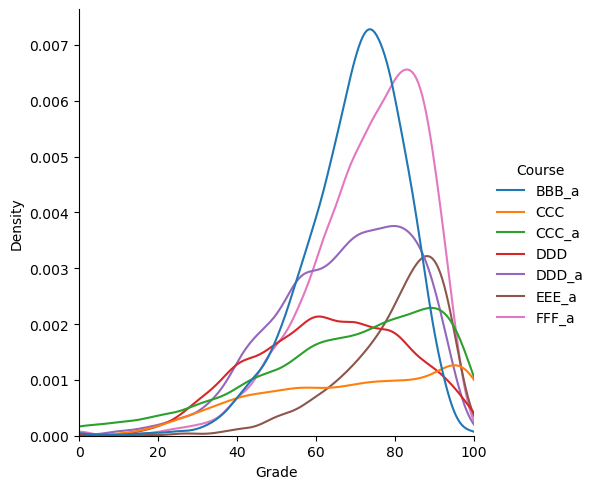

In [56]:
import seaborn as sns
sns.displot(results_network.sort_values('Course'), hue='Course', x='Grade', kind='kde', cut=0)
plt.xlim([0,100])
plt.savefig('figures/OU_gradedist.pdf')